# IBM Data Science Course Final Assignment - "Where Can I Open the New Restaurant?"

## Introduction

In this project, I will try to find out a good location to open the new restaurant in Seoul, the capital of South Korea.  
In 2019, **25% of Korean are self-employed involuntarily** because of cut-back and employment difficulties. You can find that the rate is very high, compared to other countries such as Japan(10%), US(6%), and OECD average(15%). So, I want to help the self-employed by find out how we select the place to open a store, especially a restaurant. In particular, I want to pay attention to **the number of restaurants per floating population** carefully.

## Data

1. Information of restaurants (rate, type, etc.) near the each subway station of Seoul from Foursquare, to check whether those could be huddles for a self-employed person who want to open a restaurant.

2. Location data(latitude, longitude, etc.) of the each station and restaurants from Foursquare, to analyse & visualize.

3. User number data of the each subway station from Seoul Metropolitan Government(it offers those data free), to determine some areas around the each subway is too saturated to open a new rastaurant.

\+ anything helpful to be build this project. It would be the data from Google Maps, Korean local platform(Naver, Kakao, etc.) and so on.
  
  
These data below are examples.

In [2]:
# Default Setting
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
# !pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import analysing tools from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
# !pip install folium
import folium # map rendering library

In [3]:
# User number data of the station

df = pd.read_csv("CARD_SUBWAY_MONTH_202011.csv") # Load the data about subway user number in Nov
df.columns = ["Date", "Line Number", "Stn Name", "Num of Getting on", "Num of Getting off", "To be deleted", "Me too"]

df_subway = df.groupby("Stn Name").sum()[["Num of Getting on", "Num of Getting off"]]
df_subway.head(10)

,Num of Getting on,Num of Getting off
Stn Name,,
4.19민주묘지,75412,72706
가능,168980,161685
가락시장,442072,466835
가산디지털단지,1541629,1624269
가양,520895,506716
가오리,102655,100568
가좌,139506,127933
가천대,210218,236388
가평,45516,45734


In [4]:
# location data of the station

df = pd.read_csv("Seoul_Metripolitan_Stn_Location.csv") # Load the data about subway stn. location
df_subway = pd.merge(df_subway, df, on = "Stn Name")
df_subway.head(10)

,Stn Name,Num of Getting on,Num of Getting off,lat,lng
0,가능,168980,161685,37.748577,127.044213
1,가락시장,442072,466835,37.492522,127.118234
2,가산디지털단지,1541629,1624269,37.481072,126.882343
3,가양,520895,506716,37.561391,126.854456
4,가오리,102655,100568,37.641701,127.016792
5,가좌,139506,127933,37.568491,126.915487
6,가천대,210218,236388,37.448605,127.126697
7,가평,45516,45734,37.814536,127.510739
8,간석,150736,143007,37.464737,126.694181
9,갈매,77713,66532,37.634118,127.114757


In [6]:
# count the number of famous restaurant near the each station

LIMIT = 100 # A default Foursquare API limit value
latitude = 0
longitude = 0
ACCESS_TOKEN = ""
ver = '20201231'
radius = 500
categoryId = "4d4b7105d754a06374d81259" # limit results in the food section, because many to-be-self-employeed koreans consider to open their restaurant.

restaurant_num = []

for rownum in range(len(df_subway)):
    latitude = df_subway.iloc[rownum, 3]
    longitude =  df_subway.iloc[rownum, 4]
    url1 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID,
             CLIENT_SECRET,
             latitude,
             longitude,
             ACCESS_TOKEN,
             ver,
             categoryId,
             radius,
             LIMIT)
    results = requests.get(url1).json()
    restaurant_num.append(len(results["response"]["groups"][0]["items"]))

df_subway["Restaurant Count"] = restaurant_num
df_subway["Stn User_Total"] = (df_subway["Num of Getting on"] + df_subway["Num of Getting on"])/1000
df_subway.drop(['Num of Getting on', 'Num of Getting off'], axis = 'columns', inplace = True)

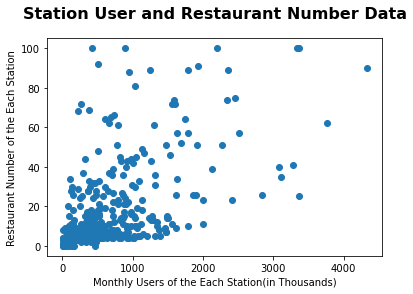

In [10]:
# make the scatter plot

X = df_subway["Stn User_Total"]
y = df_subway["Restaurant Count"]

plt.plot(X, y, 'o')
title_font = {'fontsize': 16, 'fontweight': 'bold'}
plt.title('Station User and Restaurant Number Data', fontdict=title_font, pad=20)
plt.xlabel('Monthly Users of the Each Station(in Thousands)')
plt.ylabel('Restaurant Number of the Each Station')
plt.show()

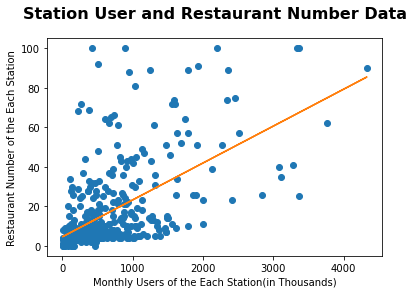

[0.01868334] 4.59492492144693


In [11]:
# Train the LR model
lr = LinearRegression().fit(X.values.reshape(-1,1), y)

plt.plot(X, y, 'o')
plt.plot(X,lr.predict(X.values.reshape(-1,1)))
plt.title('Station User and Restaurant Number Data', fontdict=title_font, pad=20)
plt.xlabel('Monthly Users of the Each Station(in Thousands)')
plt.ylabel('Restaurant Number of the Each Station')
plt.show()

print(lr.coef_, lr.intercept_)

In [12]:
# compare the predict num & real num
df_subway["add_restaurant_capa"] = lr.predict(df_subway["Stn User_Total"].values.reshape(-1, 1))- df_subway["Restaurant Count"]
df_subway.head(10)

,Stn Name,lat,lng,Restaurant Count,Stn User_Total,add_restaurant_capa
0,가능,37.748577,127.044213,4,337.960,6.909147
1,가락시장,37.492522,127.118234,24,884.144,-2.886311
2,가산디지털단지,37.481072,126.882343,40,3083.258,22.200485
3,가양,37.561391,126.854456,10,1041.790,14.059043
4,가오리,37.641701,127.016792,6,205.310,2.430802
5,가좌,37.568491,126.915487,5,279.012,4.807801
6,가천대,37.448605,127.126697,5,420.436,7.450074
7,가평,37.814536,127.510739,6,91.032,0.295707
8,간석,37.464737,126.694181,5,301.472,5.227429
9,갈매,37.634118,127.114757,5,155.426,2.498802


In [16]:
# see stations ranking where the capa is higher than others
df_subway.sort_values(by=['add_restaurant_capa'], ascending = False, axis=0).head(10)

,Stn Name,lat,lng,Restaurant Count,Stn User_Total,add_restaurant_capa
264,신림,37.484201,126.929715,25,3359.990,42.370763
262,신도림,37.508725,126.891295,26,2839.264,31.641862
309,연신내,37.619001,126.921008,11,1999.844,30.958692
180,부천,37.484050,126.782686,10,1781.502,27.879334
42,구로디지털단지,37.485266,126.901401,35,3112.038,27.738191
247,수원,37.265974,126.999874,23,2413.258,26.682647
183,부평,37.489493,126.724805,9,1610.026,25.675589
260,신대방,37.487462,126.913149,5,1389.884,25.562601
305,역곡,37.485178,126.811502,7,1474.976,25.152404
435,화곡,37.541513,126.840461,7,1466.514,24.994306
